In [1]:
from functions import *

## Source Spectrum 

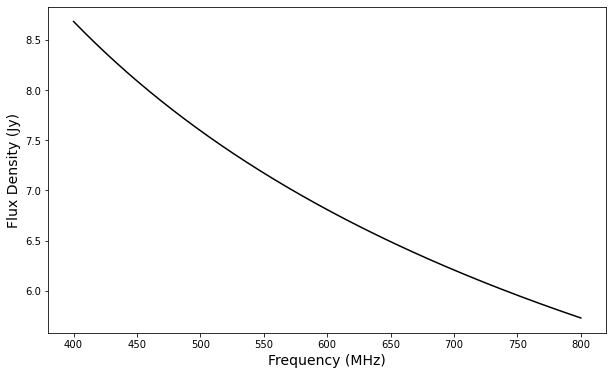

In [2]:
# Calculate the flux density of source
freqs = np.linspace(800, 400, 1024)
fluxes = flux_density(freqs)

fig = plt.figure(figsize=(10, 6))
plt.plot(freqs, fluxes, color='black')
plt.xlabel('Frequency (MHz)', fontsize=14)
plt.ylabel('Flux Density (Jy)', fontsize=14)
plt.show()

## Calibration Spectrum

### Load data

In [3]:
# Read in the data
cal = FilReader("./data/calibrator_source.fil") 
Pretty(cal.header)

Header(
    filename='./data/calibrator_source.fil',
    data_type='filterbank',
    nchans=1024,
    foff=-0.390625,
    fch1=800.0,
    nbits=32,
    tsamp=0.00032768,
    tstart=60638.353596809546,
    nsamples=30518,
    nifs=1,
    coord=<SkyCoord (ICRS): (ra, dec) in deg
    (72.26000547, 45.02999878)>,
    azimuth=<Angle 0. deg>,
    zenith=<Angle 0. deg>,
    telescope='CHIME',
    backend='CHIME',
    source='Fake',
    frame='topocentric',
    ibeam=1,
    nbeams=1,
    dm=0.0,
    period=0,
    accel=0,
    signed=0,
    rawdatafile='test.dat',
    stream_info=StreamInfo(
        entries=[
            FileInfo(
                filename='./data/calibrator_source.fil',
                hdrlen=414,
                datalen=125001728,
                nsamples=30518,
                tstart=60638.353596809546,
                tsamp=0.00032768
            )
        ]
    )
)

### Visualize

There are two obvious features that distinguish the calibrator spectrum from the source - the 30 MHz ripples, and RFI induced channels.

Output()

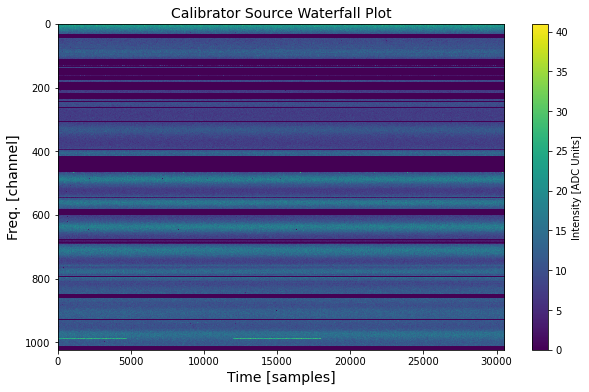

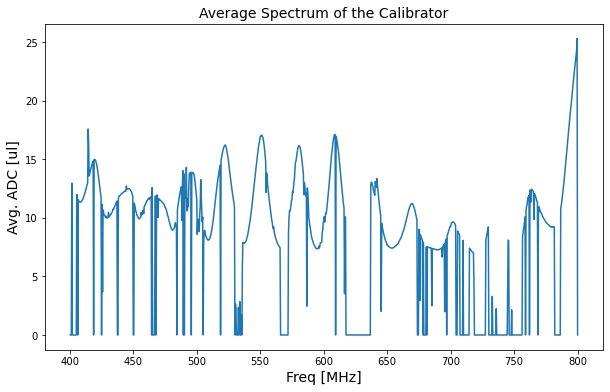

In [4]:
cal.compute_stats()
cal_data = cal.read_block(0, cal.header.nsamples, cal.header.fch1, cal.header.nchans)
cal_array = cal_data.data

# Plot the waterfall
fig = plt.figure(figsize=(10, 6))
plt.imshow(cal_array, aspect='auto', interpolation='nearest')
plt.colorbar(label='Intensity [ADC Units]')
plt.title('Calibrator Source Waterfall Plot', fontsize=14)
plt.xlabel('Time [samples]', fontsize=14)
plt.ylabel('Freq. [channel]', fontsize=14)
plt.show()

# Plot the mean spectrum
fig = plt.figure(figsize=(10, 6))
plt.plot(cal.header.chan_freqs, cal.chan_stats.mean)
plt.title('Average Spectrum of the Calibrator', fontsize=14)
plt.ylabel('Avg. ADC [ul]', fontsize=14)
plt.xlabel('Freq [MHz]', fontsize=14)
plt.show()

### RFI Masking

Output()

Output()

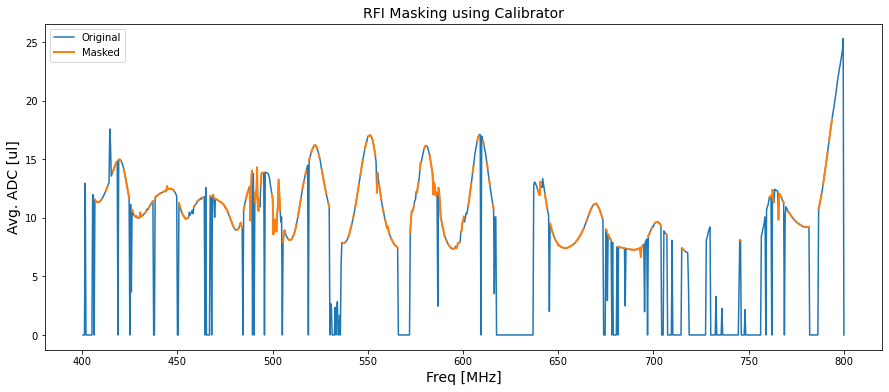

In [5]:
# Mask the RFI
_, chan_mask = cal.clean_rfi(
    method = "mad",
    threshold=3, 
    outfile_name = "./data/calibrator_source_masked.fil",
)
cal_masked = FilReader("./data/calibrator_source_masked.fil") 
cal_masked.compute_stats()

freq_mask = cal_masked.chan_stats.mean == 0
fig = plt.figure(figsize=(15, 6))
plt.plot(
    cal_masked.header.chan_freqs, 
    cal.chan_stats.mean, 
)
plt.plot(
    cal_masked.header.chan_freqs, 
    np.where(~freq_mask, cal_masked.chan_stats.mean, np.nan), 
    linewidth=2, 
)
plt.ylabel('Avg. ADC [ul]', fontsize=14)
plt.xlabel('Freq [MHz]', fontsize=14)
plt.title('RFI Masking using Calibrator', fontsize=14)
plt.legend(['Original', 'Masked'])
plt.show()

### Downsampling

Output()

Output()

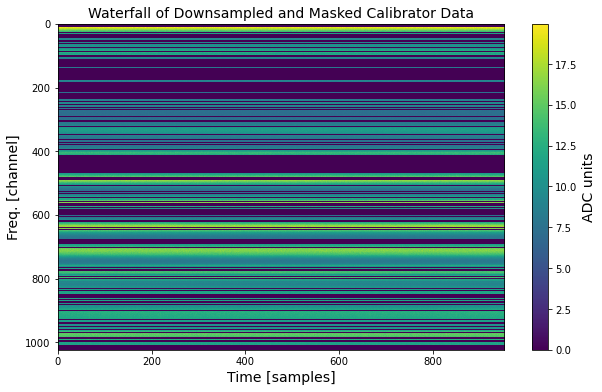

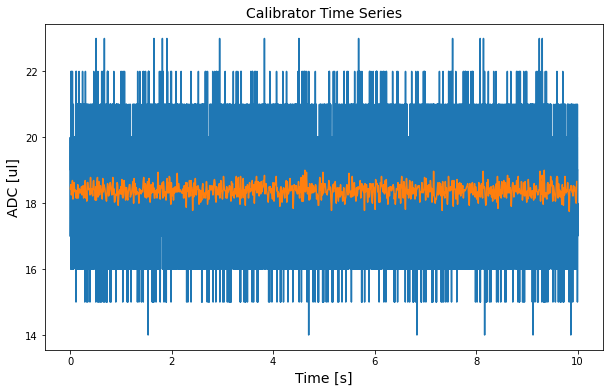

In [6]:
# Downsample the data
cal_masked.downsample(
    tfactor = 32, 
    outfile_name = "./data/calibrator_source_masked_f1_t32.fil"
)
cal_32 = FilReader("./data/calibrator_source_masked_f1_t32.fil") 
cal_32.compute_stats()
cal_data_32 = cal_32.read_block(0, cal_32.header.nsamples, cal_32.header.fch1, cal_32.header.nchans)
cal_32_array = cal_data_32.data

fig = plt.figure(figsize=(10, 6))
plt.imshow(cal_32_array,aspect='auto',interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label('ADC units', fontsize=14)
plt.title('Waterfall of Downsampled and Masked Calibrator Data', fontsize=14)
plt.xlabel('Time [samples]', fontsize=14)
plt.ylabel('Freq. [channel]', fontsize=14)
plt.show()

fig = plt.figure(figsize=(10, 6))
plt.plot(
    np.arange(cal.header.nsamples) * cal.header.tsamp,
    cal_array[~freq_mask,:][1,:]
)
plt.plot(
    np.arange(cal_32.header.nsamples) * cal_32.header.tsamp,
    cal_32_array[~freq_mask,:][1,:]
)
plt.ylabel('ADC [ul]', fontsize=14)
plt.xlabel('Time [s]', fontsize=14)
plt.title('Calibrator Time Series', fontsize=14)
plt.show()


## Transfer Function Calculation

### Calculate transfer function

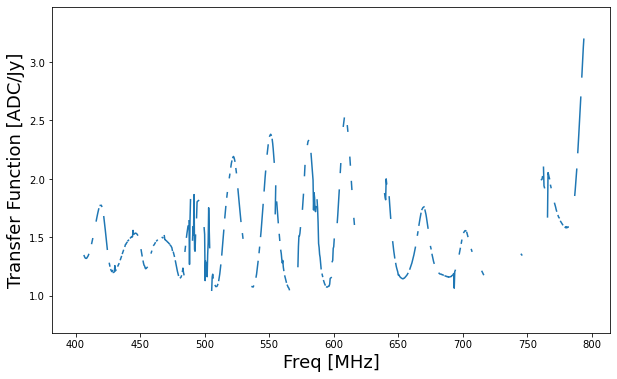

In [7]:
# We want to calculate gain with the RFI channels masked
df = np.abs(cal.header.foff) * 1e6                                              # Hz 
dt = cal.header.tsamp                                                           # s
T_sys = 50                                                                      # K               
scale = T_sys / np.sqrt(df * dt)                                                # K  

# G = observed_spectrum * scale / true_spectrum / noise 
true_spectrum = np.where(~freq_mask, fluxes, np.nan)                            # Jy
obs_spectrum = np.where(~freq_mask, cal_32.chan_stats.mean, np.nan)             # ADC
# rms_noise = np.sqrt(np.nanmean(np.square(cal_32_array[~freq_mask, :][1,:])))  # ADC
# snr = obs_spectrum / rms_noise                                                # unitless
transfer_function = np.where(
    ~freq_mask, 
    obs_spectrum / true_spectrum,                                               # ADC/Jy
    np.nan
)  

fig = plt.figure(figsize=(10, 6))
plt.plot(cal_32.header.chan_freqs, transfer_function)
plt.ylabel('Transfer Function [ADC/Jy]', fontsize=18)
plt.xlabel('Freq [MHz]', fontsize=18)
# plt.title('Response Function of the Telescope', fontsize=14)
plt.show()

### Calibrate the source data using response function

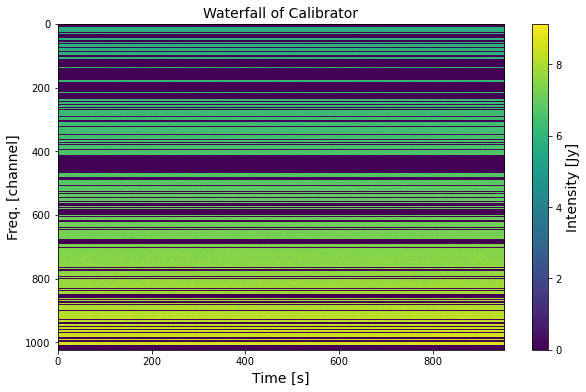

In [8]:
cal_32_array_calibrated = np.copy(cal_32_array)
cal_32_array_calibrated[~freq_mask, :] /= transfer_function[~freq_mask][:, np.newaxis]

fig = plt.figure(figsize=(10, 6))
plt.imshow(cal_32_array_calibrated, aspect='auto', interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label('Intensity [Jy]', fontsize=14)
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('Freq. [channel]', fontsize=14)
plt.title('Waterfall of Calibrator', fontsize=14)
plt.show()

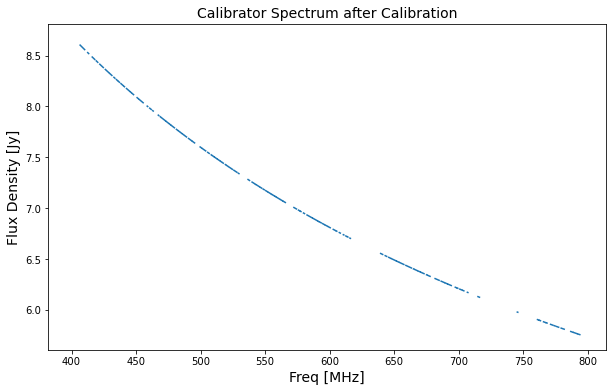

In [9]:
fig = plt.figure(figsize=(10, 6))
plt.plot(
    cal_32.header.chan_freqs, 
    np.where(~freq_mask, np.mean(cal_32_array_calibrated, axis=1), np.nan)
)
plt.ylabel('Flux Density [Jy]', fontsize=14)
plt.xlabel('Freq [MHz]', fontsize=14)
plt.title('Calibrator Spectrum after Calibration', fontsize=14)
plt.show()

### Apply Gain to Sky 

Output()

Output()

Output()

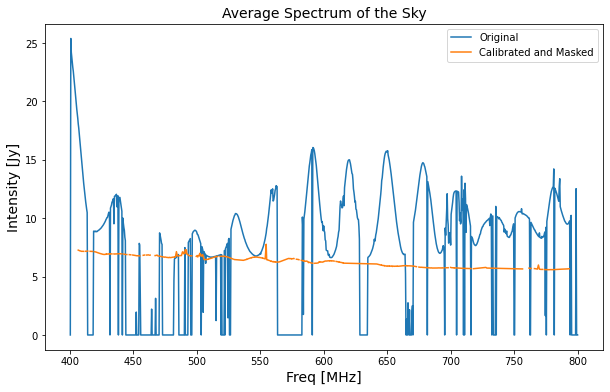

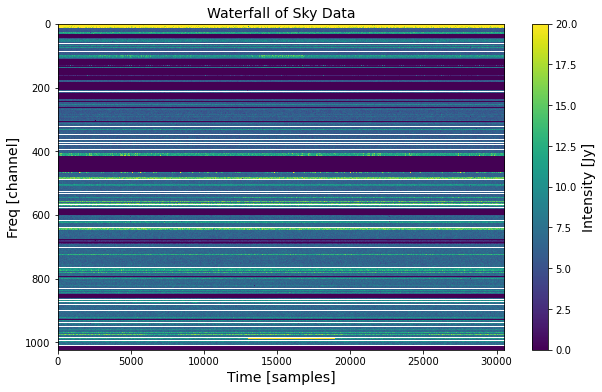

In [11]:
# Load sky data
sky = FilReader("./data/blank_sky.fil")
sky_data = sky.read_block(0, sky.header.nsamples, sky.header.fch1, sky.header.nchans)
sky_array = sky_data.data

# Mask the RFI
_, chan_mask = sky.clean_rfi(
    method = "mad",
    threshold=3, 
    outfile_name = "./data/blank_sky_masked.fil",
)
sky_masked = FilReader("./data/blank_sky_masked.fil") 
sky_masked.compute_stats()

sky_freq_mask = sky_masked.chan_stats.mean == 0
# sky_freq_mask = freq_mask

# Apply the calibration transfer function
sky_array_calibrated = np.copy(sky_array)
sky_array_calibrated[~sky_freq_mask, :] /= transfer_function[~sky_freq_mask][:, np.newaxis]

# Plot the average spectrum
fig = plt.figure(figsize=(10, 6))
plt.plot(sky.header.chan_freqs[::-1], np.mean(sky_array, axis=1))
plt.plot(sky.header.chan_freqs[~sky_freq_mask], np.mean(sky_array_calibrated[~sky_freq_mask, :], axis=1))
plt.ylabel('Intensity [Jy]', fontsize=14)
plt.xlabel('Freq [MHz]', fontsize=14)
plt.title('Average Spectrum of the Sky', fontsize=14)
plt.legend(['Original', 'Calibrated and Masked'])
plt.show()

# Create a waterfall plot
fig = plt.figure(figsize=(10, 6))
im = plt.imshow(sky_array_calibrated, aspect='auto', interpolation='nearest')
cbar = plt.colorbar(im)
im.set_clim(0, 20)
cbar.set_label('Intensity [Jy]', fontsize=14)
plt.xlabel('Time [samples]', fontsize=14)
plt.ylabel('Freq [channel]', fontsize=14)
plt.title('Waterfall of Sky Data', fontsize=14)
plt.show()

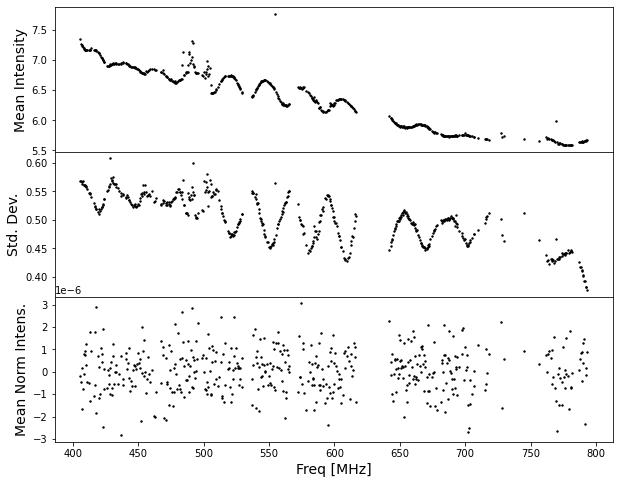

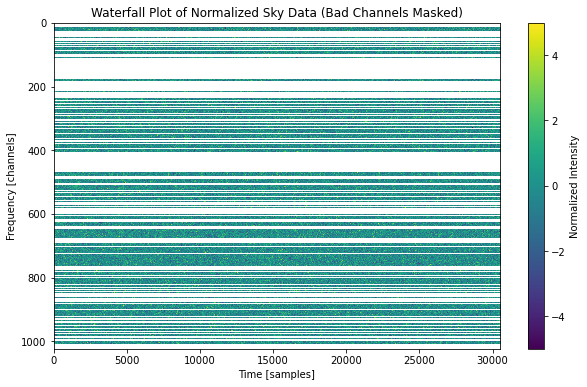

In [13]:
# Compute mean and standard deviation per channel (across time bins), filtering out bad channels
mean_per_channel = np.mean(sky_array_calibrated[~sky_freq_mask, :], axis=1)
std_per_channel = np.std(sky_array_calibrated[~sky_freq_mask, :], axis=1)

# Normalize only the valid frequency channels
sky_array_normalized = np.copy(sky_array_calibrated)
sky_array_normalized[~sky_freq_mask, :] = (sky_array_calibrated[~sky_freq_mask, :] - mean_per_channel[:, np.newaxis]) / std_per_channel[:, np.newaxis]
sky_array_normalized[sky_freq_mask, :] = np.nan

# Plot mean and standard deviation per frequency channel (excluding bad channels)
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True, gridspec_kw={'hspace': 0})
ax[0].scatter(sky.header.chan_freqs[~sky_freq_mask], mean_per_channel, color='black', s=2)
ax[0].set_ylabel('Mean Intensity', fontsize=14)
ax[0].set_xlabel('Freq [MHz]', fontsize=14)

ax[1].scatter(sky.header.chan_freqs[~sky_freq_mask], std_per_channel, color='black', s=2)
ax[1].set_ylabel('Std. Dev.', fontsize=14)
ax[1].set_xlabel('Freq [MHz]', fontsize=14)

ax[2].scatter(sky.header.chan_freqs[~sky_freq_mask], np.mean(sky_array_normalized[~sky_freq_mask, :], axis=1), color='black', s=2)
ax[2].set_ylabel('Mean Norm Intens.', fontsize=14)
ax[2].set_xlabel('Freq [MHz]', fontsize=14)
plt.show()

# Create a waterfall plot of the normalized dataset (bad channels masked)
plt.figure(figsize=(10, 6))
im = plt.imshow(sky_array_normalized, aspect='auto', interpolation='nearest', cmap='viridis')
im.set_clim(-5, 5)
plt.colorbar(im, label='Normalized Intensity')
plt.xlabel('Time [samples]')
plt.ylabel('Frequency [channels]')
plt.title('Waterfall Plot of Normalized Sky Data (Bad Channels Masked)')
plt.show()

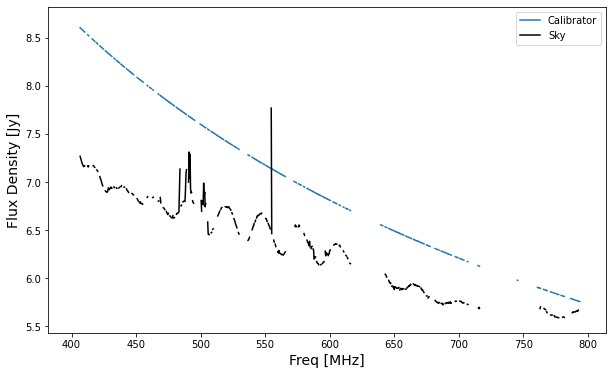

In [14]:
fig = plt.figure(figsize=(10, 6))
plt.plot(
    cal_masked.header.chan_freqs, 
    np.where(~freq_mask, np.mean(cal_32_array_calibrated, axis=1), np.nan),
    label='Calibrator'
)
plt.plot(
    sky.header.chan_freqs, 
    np.where(~(sky_freq_mask), np.mean(sky_array_calibrated, axis=1), np.nan),
    color='black',
    label='Sky'
)

plt.ylabel('Flux Density [Jy]', fontsize=14)
plt.xlabel('Freq [MHz]', fontsize=14)
plt.legend()
plt.show()